In [108]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
from pydub import AudioSegment
import whisper
from urllib.request import urlopen
import io
from tqdm import tqdm
import librosa.display

files = [
    'arousal_cont_average.csv', # each row is a song and each column is the average arousal 15-45 seconds
    'arousal_cont_std.csv', #
    'songs_info.csv', # metadata = file, artist, title, genre
    'static_annotations.csv', # overall mean and std of arousal and valence # use as source of truth for each song
    'valence_cont_average.csv', # each row is a song and each column is the average valence 15-45 seconds
    'valence_cont_std.csv'
]

### Arousal Data:
---

In [2]:
df = pd.read_csv(f'data/annotations/{files[0]}')
#print(df.info())
display(df.head(3))

,song_id,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,...,sample_40500ms,sample_41000ms,sample_41500ms,sample_42000ms,sample_42500ms,sample_43000ms,sample_43500ms,sample_44000ms,sample_44500ms,sample_45000ms
0,2,-0.109388,-0.114943,-0.116414,-0.118614,-0.126458,-0.133200,-0.136857,-0.144714,-0.138987,...,-0.259550,-0.262237,-0.261481,-0.264916,-0.265397,-0.265162,-0.264470,-0.265842,-0.267091,-0.266345
1,3,-0.110847,-0.123974,-0.131104,-0.135957,-0.140777,-0.144664,-0.163118,-0.165218,-0.158859,...,-0.265929,-0.263960,-0.263571,-0.262956,-0.260337,-0.248710,-0.245516,-0.251299,-0.254619,-0.259586
2,4,0.222328,0.179448,0.178389,0.184057,0.176043,0.178720,0.176345,0.175793,0.176155,...,0.298644,0.294144,0.302703,0.297487,0.303424,0.298097,0.304340,0.304115,0.305079,0.290705


### Valence Data
---

In [3]:
df = pd.read_csv(f'data/annotations/{files[4]}')
#print(df.info())
display(df.head(3))

,song_id,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,...,sample_40500ms,sample_41000ms,sample_41500ms,sample_42000ms,sample_42500ms,sample_43000ms,sample_43500ms,sample_44000ms,sample_44500ms,sample_45000ms
0,2,-0.073341,-0.074662,-0.074078,-0.078155,-0.081589,-0.080875,-0.083612,-0.082146,-0.081633,...,-0.324848,-0.324682,-0.328113,-0.330134,-0.330135,-0.331165,-0.331769,-0.334287,-0.333847,-0.334209
1,3,-0.189701,-0.187763,-0.183738,-0.188760,-0.193703,-0.190832,-0.189039,-0.197552,-0.202871,...,-0.313982,-0.305432,-0.294849,-0.282939,-0.276366,-0.279426,-0.278661,-0.274246,-0.270161,-0.263900
2,4,0.154287,0.148063,0.146956,0.151180,0.135941,0.076832,0.084486,0.088514,0.090945,...,0.217566,0.218894,0.222273,0.190337,0.173085,0.174891,0.179883,0.182709,0.179331,0.178671


### Song Info / Metadata
---

In [4]:
df = pd.read_csv(f'data/annotations/{files[2]}')
for col in ['file_name', 'Artist', 'Song title', 'Genre', 'Mediaeval 2013 set']:
    df[col] = df[col].str.replace(r'\t', '', regex=True)
print(df.info())
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   song_id                         744 non-null    int64  
 1   file_name                       744 non-null    object 
 2   Artist                          744 non-null    object 
 3   Song title                      744 non-null    object 
 4   start of the segment (min.sec)  744 non-null    float64
 5   end of the segment (min.sec)    744 non-null    float64
 6   Genre                           744 non-null    object 
 7   Mediaeval 2013 set              744 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 46.6+ KB
None


,song_id,file_name,Artist,Song title,start of the segment (min.sec),end of the segment (min.sec),Genre,Mediaeval 2013 set
0,2,2.mp3,The New Mystikal Troubadours,Tonight A Lonely Century,0.48,1.33,Blues,development
1,3,3.mp3,Kevin MacLeod,DD Groove,0.36,1.21,Blues,evaluation
2,4,4.mp3,Kevin MacLeod,Slow Burn,1.29,2.14,Blues,development


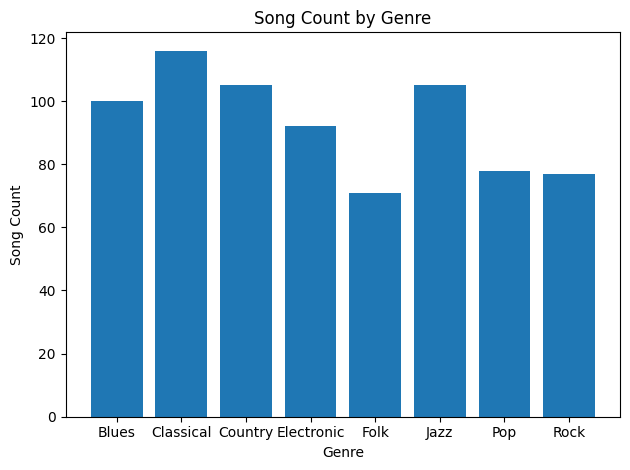

In [5]:
grp = df.groupby('Genre')['song_id'].count().reset_index()
grp.columns = ['genre', 'count']
#grp
plt.bar(grp.genre, grp['count'])
plt.title('Song Count by Genre')
plt.xlabel('Genre')
plt.ylabel('Song Count')
plt.tight_layout()

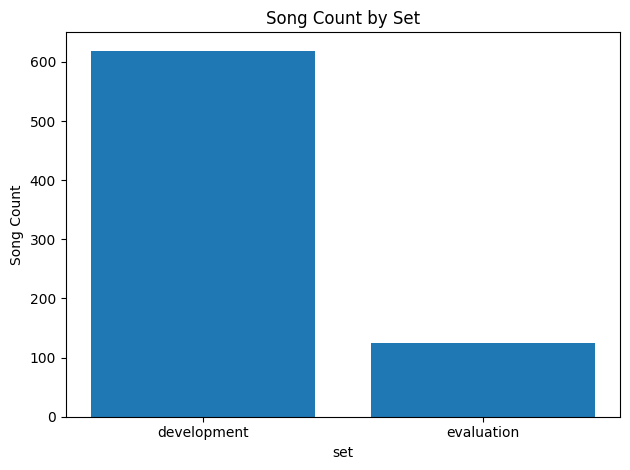

In [6]:
grp = df.groupby('Mediaeval 2013 set')['song_id'].count().reset_index()
grp.columns = ['set', 'count']

plt.bar(grp['set'], grp['count'])
plt.title('Song Count by Set')
plt.xlabel('set')
plt.ylabel('Song Count')
plt.tight_layout()

### Annotations:
---

--distributions--


,song_id,mean_arousal,std_arousal,mean_valence,std_valence,source
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.0
mean,472.801075,4.786459,1.646668,5.006063,1.564322,0.0
std,286.930192,1.376034,0.422581,1.245554,0.415570,0.0
min,2.000000,1.600000,0.632460,1.600000,0.483050,0.0
25%,218.750000,3.700000,1.364875,4.100000,1.264900,0.0
50%,450.500000,4.800000,1.649900,5.000000,1.595100,0.0
75%,718.250000,5.900000,1.932200,5.900000,1.840900,0.0
max,1000.000000,8.400000,2.846000,8.100000,2.668700,0.0


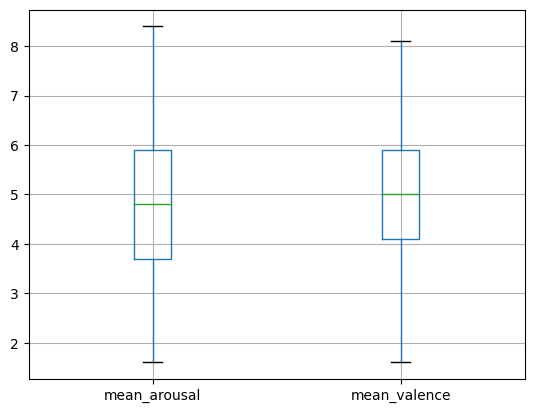

In [55]:
annot = pd.read_csv(f'data/annotations/{files[3]}')
annot['file'] = annot['song_id'].astype(str) + ".mp3"
annot['source'] = 0
#print(df.info())
#display(annot.head(3))
print('--distributions--')
display(annot.describe())
annot[['mean_arousal', 'mean_valence']].boxplot()

static = annot.copy()[['song_id', 'file', 'mean_valence', 'source']]
static.columns = ['id', 'file', 'valence', 'source']

### Spotify Data:
---

In [18]:
def scale_valence(old, new_range):
    orange = old.max() - old.min()
    nrange = new_range.max() - new_range.min()
    scaled = [(((x - old.min()) * nrange) / orange) + new_range.min() for x in old]
    return scaled

In [53]:
df = pd.read_csv('data/spotify_data.csv').dropna()
df1 = df[df['valence'] != 0]
df1['v2'] = scale_valence(df1['valence'], pd.Series([1.5,8.5]))
df1['source'] = 1
print(df1.columns)

spot = df1.copy()[['id', 'preview_url', 'v2', 'source']]
spot.columns = ['id', 'file', 'valence', 'source']

display(spot.head())
display(spot.describe())

Index(['Unnamed: 0', 'id', 'name', 'preview_url', 'artist', 'duration',
       'popularity', 'release_date', 'valence', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'tempo', 'v2', 'source'],
      dtype='object')


/var/folders/zl/dcf4_q9d3snfp2mjbl4tx00w0000gp/T/ipykernel_13909/1630343036.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['v2'] = scale_valence(df1['valence'], pd.Series([1.5,8.5]))
/var/folders/zl/dcf4_q9d3snfp2mjbl4tx00w0000gp/T/ipykernel_13909/1630343036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['source'] = 1


,id,file,valence,source
1,2gvmxusSOe3vNjNDjQWaso,https://p.scdn.co/mp3-preview/3fe2637a3df4c31f...,6.755521,1
2,05U9HuyMUW4NllNlBCRMrN,https://p.scdn.co/mp3-preview/97a782881a1ad4df...,3.877497,1
4,74NJyJ0j5wvG1e5jpUh68o,https://p.scdn.co/mp3-preview/9c52197004f03647...,6.542061,1
5,1taGkdO3DQsNRIQrarhVvc,https://p.scdn.co/mp3-preview/1f2c82b59c850d07...,7.241325,1
6,6slWUMiyoNNWcQGu6tkTlH,https://p.scdn.co/mp3-preview/3250d3dc4f176b12...,5.312829,1


,valence,source
count,6765.000000,6765.0
mean,4.964889,1.0
std,1.686383,0.0
min,1.500000,1.0
25%,3.664038,1.0
50%,4.959516,1.0
75%,6.232913,1.0
max,8.500000,1.0


In [6]:
from audiologic.utils import transcribe_audio

res = transcribe_audio(spot.iloc[1]['preview_url'])
res.text

"You're wondering if one day we'll find a way to free from this phase Is it okay to have feelings? But if one day there is more to this game However now just keep it a secret Sweet as the halls to a gable"

In [65]:
def get_tempo(spotify_url):
    wav = io.BytesIO()
    with urlopen(spotify_url) as r:
        r.seek = lambda *args: None  # allow pydub to call seek(0)
        AudioSegment.from_file(r).export(wav, "wav")

    wav.seek(0)
    y, sr = librosa.load(wav)
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    #print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
    return tempo

get_tempo(spot.iloc[1]['preview_url'])

Estimated tempo: 103.36 beats per minute


103.359375

### All Music Data with Features
---

In [119]:
data = pd.read_csv('data/full_data_df.csv')
music = data.copy()[data['tempo'] != 0].reset_index(drop=True)
#music = music.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7506 entries, 0 to 7505
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           7506 non-null   object 
 1   file         7506 non-null   object 
 2   valence      7506 non-null   float64
 3   source       7506 non-null   int64  
 4   tempo        7506 non-null   float64
 5   beat_length  7506 non-null   int64  
 6   beat_diff    7501 non-null   float64
 7   frame_1      7506 non-null   float64
 8   frame_2      7506 non-null   float64
 9   frame_3      7506 non-null   float64
 10  frame_4      7506 non-null   float64
 11  frame_5      7506 non-null   float64
 12  frame_6      7506 non-null   float64
 13  frame_7      7506 non-null   float64
 14  frame_8      7506 non-null   float64
 15  frame_9      7506 non-null   float64
 16  frame_10     7506 non-null   float64
 17  frame_11     7506 non-null   float64
 18  frame_12     7506 non-null   float64
 19  frame_

In [120]:
music.columns

Index(['id', 'file', 'valence', 'source', 'tempo', 'beat_length', 'beat_diff',
       'frame_1', 'frame_2', 'frame_3', 'frame_4', 'frame_5', 'frame_6',
       'frame_7', 'frame_8', 'frame_9', 'frame_10', 'frame_11', 'frame_12',
       'frame_13', 'frame_14', 'frame_15', 'frame_16', 'frame_17', 'frame_18',
       'frame_19', 'frame_20', 'frame_21', 'frame_22', 'frame_23', 'frame_24',
       'frame_25', 'frame_26', 'frame_27', 'frame_28', 'frame_29', 'frame_30'],
      dtype='object')

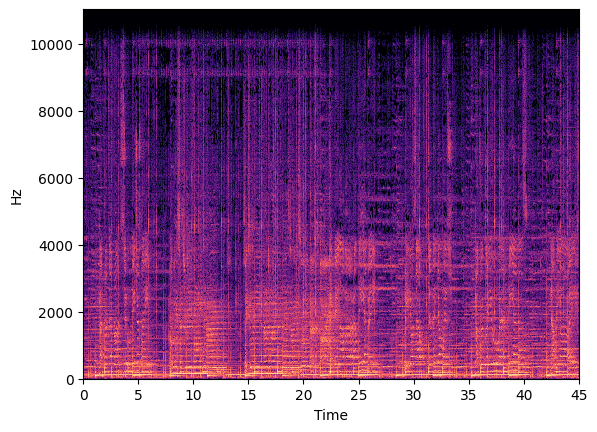

In [113]:
# Mel Spectrogram images

y, sr = librosa.load('data/wav45/2.wav')#, res_type='kaiser_fast')
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

#fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear')#, ax=ax)
#ax.set(title='Now with labeled axes!')
#fig.colorbar(img, ax=ax, format="%+2.f dB")
img

## Extra Functions to create static data
---

In [3]:
def remove_missing_mp3():
    ls = list(range(1, 1001))
    song_truth = pd.read_csv(f'data/annotations/{files[3]}')
    exclude = set(ls) ^ set(song_truth['song_id'])

    for n in exclude:
        file = f"data/clips_45seconds/{n}.mp3"
        if os.path.exists(file):
            os.remove(file)

#remove_missing_mp3()

In [4]:
# TODO: convert mp3 to wav using pydub package
# REQUIRES FFMPEG

def wav_conversion():
    from pydub import AudioSegment
    song_truth = pd.read_csv(f'data/annotations/{files[3]}')

    for n in song_truth['song_id']:
        file = f"data/clips_45seconds/{n}.mp3"
        wav_output = f"data/wav45/{n}.wav"
        audio = AudioSegment.from_mp3(file)
        audio.export(wav_output, format="wav")

In [5]:
from audiologic.utils import transcribe_audio
import whisper

def lyricize():
    song_truth = pd.read_csv(f'data/annotations/{files[3]}')
    model = whisper.load_model('base')

    lyric_dict = {'song_id':[], 'lyrics':[]}
    for n in song_truth['song_id']:
        file = f"data/clips_45seconds/{n}.mp3"
        txt = transcribe_audio(file, preloaded_model=model)
        lyric_dict['song_id'].append(n)
        lyric_dict['lyrics'].append(txt.text)
    
    df = pd.DataFrame(lyric_dict)

    return df

#df_lyric = lyricize()
#df_lyric.to_csv('data/lyrics.csv')
#df_lyric.head()

/Users/Ty/Code/Practicum/audiologic/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
# combine mediaeval and spotify data with added features
#SINGLE
def get_tempo_beat(spotify_url):
    wav = io.BytesIO()
    with urlopen(spotify_url) as r:
        r.seek = lambda *args: None  # allow pydub to call seek(0)
        AudioSegment.from_file(r).export(wav, "wav")

    wav.seek(0)
    y, sr = librosa.load(wav)
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    #print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
    return tempo, len(beat_frames), np.mean([c-a for a, c in zip(beat_frames[:-1], beat_frames[1:])])

# Dataframe
def add_tempo_beat(dataframe):
    df = dataframe.copy()
    tt = []
    bc = []
    bd = []
    for row in tqdm(range(len(df))):
        #print(df.iloc[row]['file'])
        if df.iloc[row]['source'] == 1:
            wav = io.BytesIO()
            with urlopen(df.iloc[row]['file']) as r:
                r.seek = lambda *args: None  # allow pydub to call seek(0)
                AudioSegment.from_file(r).export(wav, "wav")
            wav.seek(0)
        else:
            wav = f"data/wav45/{df.iloc[row]['id']}.wav"

        y, sr = librosa.load(wav)
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        tt.append(tempo)
        bc.append(len(beat_frames))
        bd.append(np.mean([c-a for a, c in zip(beat_frames[:-1], beat_frames[1:])]))

    df['tempo'], df['beat_length'], df['beat_diff'] = tt, bc, bd
    return df
    
#full = add_tempo_beat(static[static['id'] <= 17])
#full = add_tempo_beat(spot.iloc[:10])

100%|██████████| 10/10 [00:29<00:00,  2.90s/it]
